In [ ]:
from google.colab import files
uploaded=files.upload()

Saving QVI_data.csv to QVI_data.csv


In [ ]:
import pandas as pd

data_df= pd.read_csv('QVI_data.csv')

In [ ]:
data_df['DATE']= pd.to_datetime(data_df['DATE'], format= '%Y-%m-%d', errors='coerce')

In [ ]:
data_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   LYLTY_CARD_NBR    264834 non-null  int64         
 1   DATE              264834 non-null  datetime64[ns]
 2   STORE_NBR         264834 non-null  int64         
 3   TXN_ID            264834 non-null  int64         
 4   PROD_NBR          264834 non-null  int64         
 5   PROD_NAME         264834 non-null  object        
 6   PROD_QTY          264834 non-null  int64         
 7   TOT_SALES         264834 non-null  float64       
 8   PACK_SIZE         264834 non-null  int64         
 9   BRAND             264834 non-null  object        
 10  LIFESTAGE         264834 non-null  object        
 11  PREMIUM_CUSTOMER  264834 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(6), object(4)
memory usage: 24.2+ MB


In [ ]:
data_df['MONTH']= data_df['DATE'].dt.to_period('M')
pre_trial_months= pd.period_range(start='2018-07', end='2019-01', freq= 'M')  # Define pre-trial period
pre_trial_df = data_df[data_df['MONTH'].isin(pre_trial_months)]

In [ ]:
tot_sales= pre_trial_df.groupby(['STORE_NBR', 'MONTH'])['TOT_SALES'].sum()
tot_customers= pre_trial_df.groupby(['STORE_NBR', 'MONTH'])['LYLTY_CARD_NBR'].nunique()
tot_transactions= pre_trial_df.groupby(['STORE_NBR', 'MONTH'])['TXN_ID'].nunique()


In [ ]:
trans_per_customer= tot_transactions/tot_customers
print(trans_per_customer)


STORE_NBR  MONTH  
1          2018-07    1.061224
           2018-08    1.023810
           2018-09    1.050847
           2018-10    1.022727
           2018-11    1.021739
                        ...   
272        2018-09    1.125000
           2018-10    1.136364
           2018-11    1.097561
           2018-12    1.000000
           2019-01    1.086957
Length: 1848, dtype: float64


In [ ]:
metrics_df = pd.DataFrame({                                    #Combining all metrics in one DataFrame
    'total_sales': tot_sales,
    'total_customers': tot_customers,
    'total_transactions': tot_transactions,
    'transactions_per_customer': trans_per_customer
}).reset_index()

metrics_df.head()

,STORE_NBR,MONTH,total_sales,total_customers,total_transactions,transactions_per_customer
0,1,2018-07,206.9,49,52,1.061224
1,1,2018-08,176.1,42,43,1.023810
2,1,2018-09,278.8,59,62,1.050847
3,1,2018-10,188.1,44,45,1.022727
4,1,2018-11,192.6,46,47,1.021739


Filter to stores present in all pre-trial months.

In [ ]:
store_counts= metrics_df['STORE_NBR'].value_counts()

valid_stores= store_counts[store_counts==7].index

filtered_df= metrics_df[metrics_df['STORE_NBR'].isin(valid_stores)]

In [ ]:
print(filtered_df['STORE_NBR'].nunique())

260


Calculating Avg price per unit & Chips per customer

In [ ]:
avg_price_per_unit= filtered_df['total_sales']/filtered_df['total_transactions']
filtered_df['avg_price_per_unit']= avg_price_per_unit

chips_per_customer= filtered_df['total_transactions']/filtered_df['total_customers']
filtered_df['chips_per_customer']= chips_per_customer

/tmp/ipython-input-11-1395450573.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['avg_price_per_unit']= avg_price_per_unit
/tmp/ipython-input-11-1395450573.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['chips_per_customer']= chips_per_customer


In [ ]:
filtered_df.head()

,STORE_NBR,MONTH,total_sales,total_customers,total_transactions,transactions_per_customer,avg_price_per_unit,chips_per_customer
0,1,2018-07,206.9,49,52,1.061224,3.978846,1.061224
1,1,2018-08,176.1,42,43,1.023810,4.095349,1.023810
2,1,2018-09,278.8,59,62,1.050847,4.496774,1.050847
3,1,2018-10,188.1,44,45,1.022727,4.180000,1.022727
4,1,2018-11,192.6,46,47,1.021739,4.097872,1.021739


In [ ]:


def get_correlation_scores(filtered_df, trial_store, metric_col='total_sales'):

    trial_sales= filtered_df[filtered_df['STORE_NBR']==trial_store][['MONTH', metric_col]]
    correlations=[]


    other_stores = filtered_df['STORE_NBR'].unique()
    other_stores= other_stores[other_stores != trial_store]

    for store in other_stores:

        store_sales = filtered_df[filtered_df['STORE_NBR'] == store][['MONTH', metric_col]]
        merged = trial_sales.merge(store_sales, on='MONTH', suffixes=('_trial', '_store'))

        corr = merged[f'{metric_col}_trial'].corr(merged[f'{metric_col}_store'])

        correlations.append((store, corr))

    correlation_df = pd.DataFrame(correlations, columns=['STORE_NBR', 'correlation'])
    correlation_df = correlation_df.sort_values(by='correlation', ascending=False)

    return correlation_df


Usage Example

In [ ]:
trial_store = 77

# Get correlation scores
correlation_df = get_correlation_scores(filtered_df, trial_store)
print(correlation_df.head())

     STORE_NBR  correlation
67          71     0.914106
220        233     0.903774
110        119     0.867664
15          17     0.842668
2            3     0.806644


In [ ]:
def get_mag_distance_scores (filtered_df, trial_store, metric_col='total_sales'):

    trial_sales= filtered_df[filtered_df['STORE_NBR']==trial_store][['MONTH', metric_col]]
    distances=[]

    other_stores = filtered_df['STORE_NBR'].unique()
    other_stores= other_stores[other_stores != trial_store]

    for store in other_stores:

        store_sales= filtered_df[filtered_df['STORE_NBR']==store][['MONTH', metric_col]]
        merged= trial_sales.merge(store_sales, on= 'MONTH', suffixes=('_trial', '_store'))

        abs_diff= abs(merged[f'{metric_col}_trial']- merged[f'{metric_col}_store'])

        # Sum total distance over the months
        distance = abs_diff.sum()

        distances.append((store, distance))

    distance_df= pd.DataFrame(distances, columns=['STORE_NBR', 'total_distance'])

    # Standardize the distance using min-max scaling to convert it into a similarity score
    min_dist = distance_df['total_distance'].min()
    max_dist = distance_df['total_distance'].max()


    distance_df['magnitude_score']= 1- (distance_df['total_distance']-min_dist)/(max_dist-min_dist)

    distance_df= distance_df.sort_values(by='magnitude_score', ascending=False)

    return distance_df

In [ ]:
trial_store=77
mag_score_df= get_mag_distance_scores(filtered_df, trial_store)
print(mag_score_df.head())

     STORE_NBR  total_distance  magnitude_score
220        233           131.8         1.000000
241        255           200.0         0.991889
179        188           217.7         0.989784
49          53           227.3         0.988642
122        131           231.3         0.988167


Calculating Correlation & Magnitude scores on total sales and total customers

In [ ]:
corr_sales_77= get_correlation_scores(filtered_df, 77, metric_col='total_sales')

corr_customers_77= get_correlation_scores(filtered_df, 77, metric_col='total_customers')

mag_sales_77= get_mag_distance_scores(filtered_df, 77, metric_col='total_sales')

mag_customers_77= get_mag_distance_scores(filtered_df, 77, metric_col='total_customers')

In [ ]:
sales_scores= corr_sales_77.merge(mag_sales_77, on='STORE_NBR')
sales_scores['sales_score']= sales_scores['correlation'] + sales_scores['magnitude_score'] / 2

customer_scores= corr_customers_77.merge(mag_customers_77, on='STORE_NBR')
customer_scores['customer_score']= customer_scores['correlation'] + customer_scores['magnitude_score'] / 2

In [ ]:
final_scores= sales_scores[['STORE_NBR', 'sales_score']].merge(customer_scores[['STORE_NBR','customer_score']], on='STORE_NBR')
final_scores['final_score']= final_scores['sales_score'] + final_scores['customer_score'] / 2
final_scores.sort_values(by='final_score', ascending=False)

#The store with the highest final score is 233. So 233 is a control store for the trial store 77.


,STORE_NBR,sales_score,customer_score,final_score
1,233,1.403774,1.490358,2.148953
5,41,1.272195,1.334960,1.939675
3,17,1.285731,1.231876,1.901669
6,50,1.257253,1.071125,1.792816
11,115,1.160509,1.204221,1.762619
...,...,...,...,...
245,102,-0.315761,-0.465027,-0.548274
250,55,-0.442680,-0.216461,-0.550910
251,19,-0.392823,-0.375737,-0.580691
248,247,-0.377662,-0.418102,-0.586713


Visualizing the Trial & Control Store with respect to Total Sales and Total Customers

/tmp/ipython-input-20-3309475061.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['MONTH'] = plot_df['MONTH'].dt.to_timestamp()


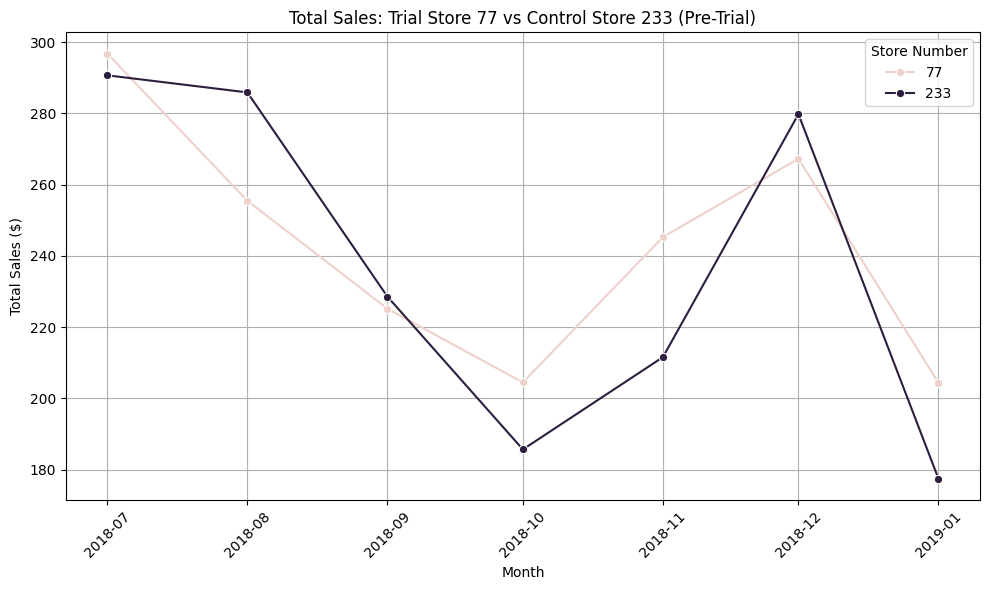

In [ ]:
control_store= 233
trial_store=77

plot_df = filtered_df[filtered_df['STORE_NBR'].isin([trial_store, control_store])]
plot_df['MONTH'] = plot_df['MONTH'].dt.to_timestamp()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.lineplot(data=plot_df, x='MONTH', y='total_sales', hue='STORE_NBR', marker='o')

plt.title(f'Total Sales: Trial Store {trial_store} vs Control Store {control_store} (Pre-Trial)')
plt.xlabel('Month')
plt.ylabel('Total Sales ($)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Store Number')
plt.tight_layout()
plt.show()

/tmp/ipython-input-21-1691477018.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['MONTH'] = plot_df['MONTH'].dt.to_timestamp()


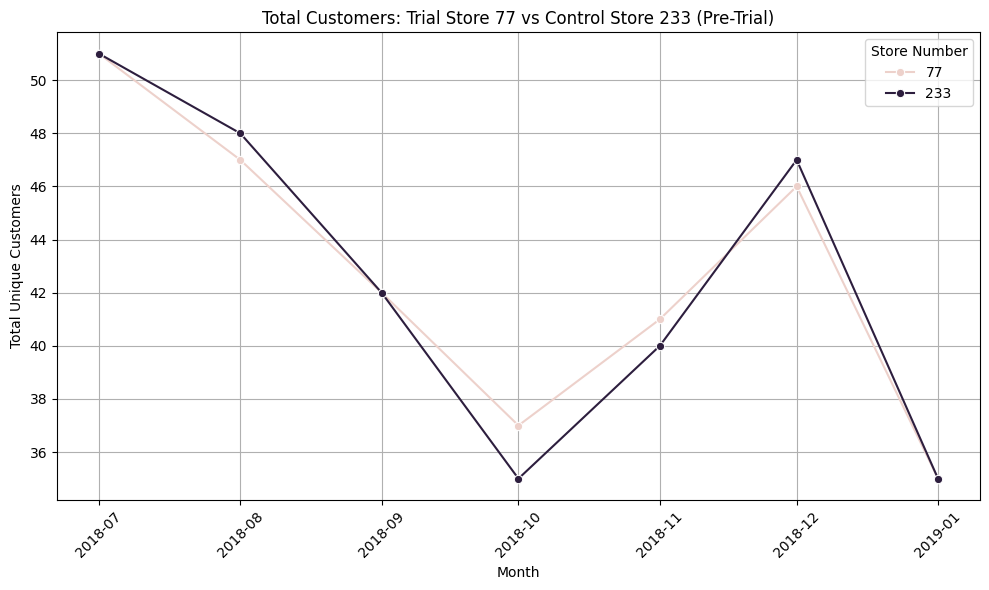

In [ ]:
control_store= 233
trial_store=77

plot_df = filtered_df[filtered_df['STORE_NBR'].isin([trial_store, control_store])]
plot_df['MONTH'] = plot_df['MONTH'].dt.to_timestamp()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.lineplot(data=plot_df, x='MONTH', y='total_customers', hue='STORE_NBR', marker='o')

plt.title(f'Total Customers: Trial Store {trial_store} vs Control Store {control_store} (Pre-Trial)')
plt.xlabel('Month')
plt.ylabel('Total Unique Customers')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Store Number')
plt.tight_layout()
plt.show()

Uplift Testing

In [ ]:

trial_months= pd.period_range(start='2019-02', end='2019-04', freq= 'M')

trial_sales_pre = filtered_df[filtered_df['STORE_NBR'] == trial_store]['total_sales'].sum()
control_sales_pre = filtered_df[filtered_df['STORE_NBR'] == control_store]['total_sales'].sum()

In [ ]:
scaling_factor = trial_sales_pre / control_sales_pre   #Scaling the sales

In [ ]:
# filtered_df['scaled_sales'] = filtered_df.apply(lambda row: row['total_sales'] * scaling_factor if row['STORE_NBR']==trial_store else row['total_sales'], axis=1)

Recalculating metrics for trial period only

In [ ]:
control_store= 233
trial_store= 77

trial_period_df= data_df[data_df['MONTH'].isin(trial_months)]

tot_sales_trial= trial_period_df.groupby(['STORE_NBR', 'MONTH'])['TOT_SALES'].sum()
tot_customers_trial= trial_period_df.groupby(['STORE_NBR', 'MONTH'])['LYLTY_CARD_NBR'].nunique()
tot_transactions_trial= trial_period_df.groupby(['STORE_NBR', 'MONTH'])['TXN_ID'].nunique()

metrics_df_trial = pd.DataFrame({                                    #Combining all metrics in one DataFrame
    'total_sales': tot_sales_trial,
    'total_customers': tot_customers_trial,
    'total_transactions': tot_transactions_trial,
}).reset_index()

metrics_df_trial['scaled_sales'] = metrics_df_trial.apply(lambda row: row['total_sales'] * scaling_factor if row['STORE_NBR']==control_store else row['total_sales'], axis=1)
metrics_df_trial = metrics_df_trial[
    metrics_df_trial['STORE_NBR'].isin([trial_store, control_store])
]

comparison_df = metrics_df_trial.pivot(index='MONTH', columns='STORE_NBR', values=['total_sales', 'scaled_sales'])

In [ ]:
# control_sales_df = comparison_df[comparison_df['STORE_NBR'] == 233][['MONTH', 'scaled_sales']].rename(columns={'scaled_sales': 'control_sales'})
comparison_df.head()


total_sales        scaled_sales            
STORE_NBR         77     233          77          233
MONTH                                                
2019-02         235.0  244.0        235.0  249.762622
2019-03         278.5  199.1        278.5  203.802205
2019-04         263.5  158.6        263.5  162.345704

In [ ]:
comparison_df['percentage_difference']= ((comparison_df[('total_sales', trial_store)] - comparison_df[('scaled_sales', control_store)]) / comparison_df[('scaled_sales', control_store)]) * 100


In [ ]:
comparison_df

total_sales        scaled_sales             percentage_difference
STORE_NBR          77    233           77         233                      
MONTH                                                                      
2019-02         235.0  244.0        235.0  249.762622             -5.910661
2019-03         278.5  199.1        278.5  203.802205             36.652103
2019-04         263.5  158.6        263.5  162.345704             62.307960

Percentage difference for pre-trial months to calculate Standard Deviation

In [ ]:
trial_store=77
control_store= 233

filtered_df['scaled_sales'] = filtered_df.apply(lambda row: row['total_sales'] * scaling_factor if row['STORE_NBR']==control_store else row['total_sales'], axis=1)
filtered_df= filtered_df[
    filtered_df['STORE_NBR'].isin([trial_store, control_store])
]

comparison_df_pre = filtered_df.pivot(index='MONTH', columns='STORE_NBR', values=['total_sales', 'scaled_sales'])

pct_diff_pre = (
    (comparison_df_pre[('total_sales', trial_store)] - comparison_df_pre[('scaled_sales', control_store)]) /
    comparison_df_pre[('scaled_sales', control_store)]) *100

/tmp/ipython-input-29-1980347816.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['scaled_sales'] = filtered_df.apply(lambda row: row['total_sales'] * scaling_factor if row['STORE_NBR']==control_store else row['total_sales'], axis=1)


In [ ]:
print(pct_diff_pre)

MONTH
2018-07    -0.257271
2018-08   -12.694997
2018-09    -3.760238
2018-10     7.583035
2018-11    13.251579
2018-12    -6.671641
2019-01    12.498029
Freq: M, dtype: float64


In [ ]:
std_dev = pct_diff_pre.std()
print(std_dev)

9.958646884078389


In [ ]:
t_values= comparison_df['percentage_difference']/std_dev
print(t_values)



MONTH
2019-02   -0.593520
2019-03    3.680430
2019-04    6.256669
Freq: M, Name: percentage_difference, dtype: float64


Calculating t-critical value

In [ ]:
from scipy.stats import t

t_critical= t.ppf(0.95, df=7)
print('t-values for trial period',t_values,
      '\n','t-critical', t_critical)

t-values for trial period MONTH
2019-02   -0.593520
2019-03    3.680430
2019-04    6.256669
Freq: M, Name: percentage_difference, dtype: float64 
 t-critical 1.894578605061305


t_feb < t_critical
t_mar > t_critical
t_apr > t_critical.
Thus, we reject the null hypothesis for March & April.

We found that there was an uplift in total sales during the trial period, the uplift was statistically significant at the 95% confidence level in March and April and not in Feb, when compared to the control store's scaled performance.

So, this suggests that the trial was effective in driving a meaningful uplift in sales during these months. The company can consider rolling out the trial strategy to other stores, as the results show a statistically significant uplift during the trial period.

Plotting the combined visual

In [ ]:
import numpy as np

pre_control = filtered_df[
    (filtered_df['STORE_NBR']==233)&
    (filtered_df['MONTH'].isin(pd.period_range('2018-07','2019-01',freq='M')))
]['total_sales'] * scaling_factor
std_dev = pre_control.std()
mean_sales = pre_control.mean()
std_dev_ratio = std_dev / mean_sales

upper_threshold = mean_sales + 2 * std_dev
lower_threshold = mean_sales - 2 * std_dev

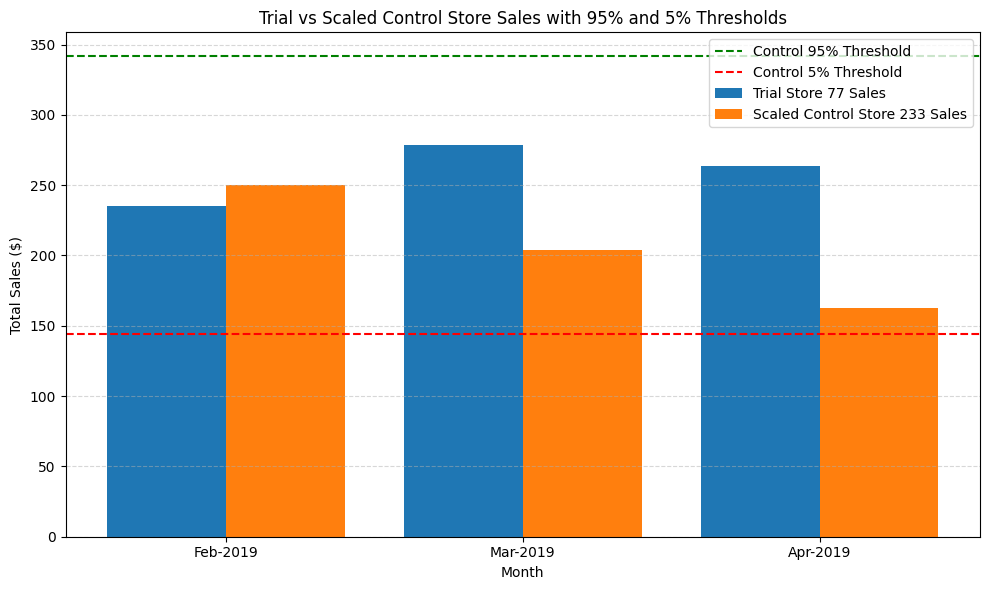

In [ ]:
import matplotlib.pyplot as plt

# Data for trial period
trial_months = pd.period_range(start='2019-02', end='2019-04', freq='M')

comparison_plot_df = comparison_df.reset_index()
months = comparison_plot_df['MONTH'].dt.to_timestamp()

trial_sales = comparison_plot_df[('total_sales', 77)]
control_sales = comparison_plot_df[('scaled_sales', 233)]

x = range(len(months))

plt.figure(figsize=(10,6))

# Bar chart
plt.bar(x, trial_sales, width=0.4, label='Trial Store 77 Sales', align='center')
plt.bar([i + 0.4 for i in x], control_sales, width=0.4, label='Scaled Control Store 233 Sales', align='center')

# Threshold lines
plt.axhline(y=upper_threshold, color='green', linestyle='--', label='Control 95% Threshold')
plt.axhline(y=lower_threshold, color='red', linestyle='--', label='Control 5% Threshold')

# Labels and formatting
plt.xticks([i + 0.2 for i in x], [m.strftime('%b-%Y') for m in months])
plt.title('Trial vs Scaled Control Store Sales with 95% and 5% Thresholds')
plt.xlabel('Month')
plt.ylabel('Total Sales ($)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
print("Trial Pre-Trial Sales:", trial_sales_pre)
print("Control Pre-Trial Sales:", control_sales_pre)
print("Scaling Factor:", scaling_factor)

Trial Pre-Trial Sales: 1699.0
Control Pre-Trial Sales: 1659.7999999999997
Scaling Factor: 1.023617303289553


In [ ]:
print("Upper Threshold (95%):", upper_threshold)
print("Lower Threshold (5%):", lower_threshold)

Upper Threshold (95%): 341.58500916939136
Lower Threshold (5%): 143.84356225918012


In [ ]:
print("Trial Sales During Trial Period:\n", trial_sales.values)
print("Scaled Control Sales During Trial Period:\n", control_sales.values)

Trial Sales During Trial Period:
 [235.  278.5 263.5]
Scaled Control Sales During Trial Period:
 [249.762622   203.80220508 162.3457043 ]


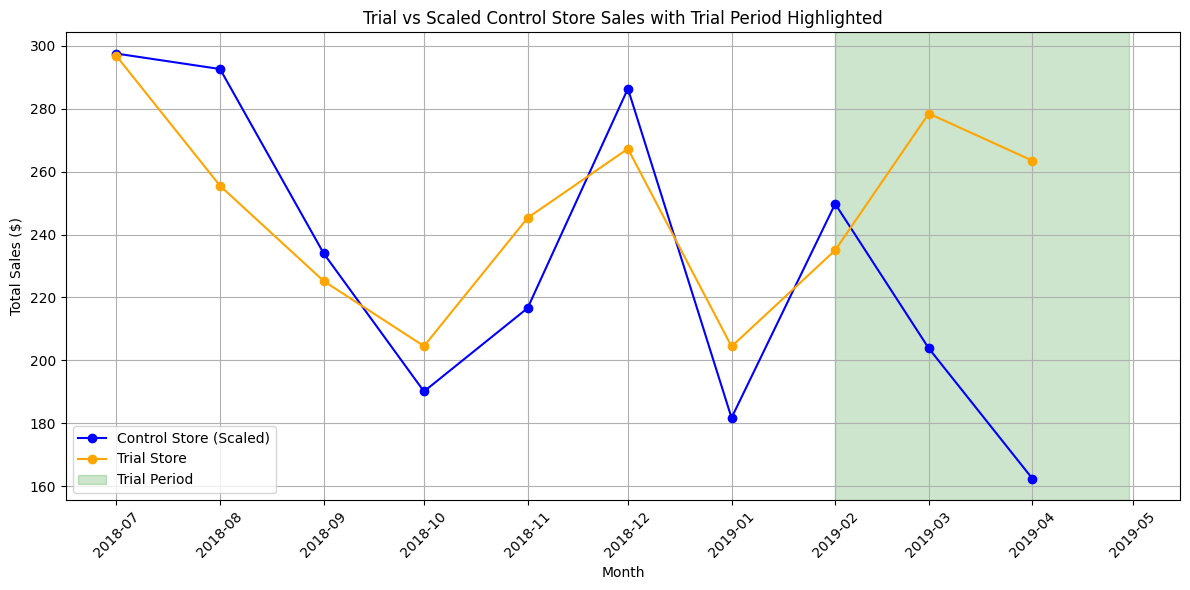

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'MONTH' is timestamp for consistent plotting
filtered_df['MONTH'] = filtered_df['MONTH'].dt.to_timestamp()
metrics_df_trial['MONTH'] = metrics_df_trial['MONTH'].dt.to_timestamp()

# Combine pre-trial and trial data
plot_pre = filtered_df[['MONTH', 'STORE_NBR', 'scaled_sales', 'total_sales']]
plot_trial = metrics_df_trial[['MONTH', 'STORE_NBR', 'scaled_sales', 'total_sales']]
plot_df = pd.concat([plot_pre, plot_trial], ignore_index=True)

# Create control and trial DataFrames
trial_store = 77
control_store = 233

trial_df = plot_df[plot_df['STORE_NBR'] == trial_store].sort_values('MONTH')
control_df = plot_df[plot_df['STORE_NBR'] == control_store].sort_values('MONTH')

# Plot
plt.figure(figsize=(12, 6))

plt.plot(control_df['MONTH'], control_df['scaled_sales'],
         label='Control Store (Scaled)', color='blue', marker='o')
plt.plot(trial_df['MONTH'], trial_df['total_sales'],
         label='Trial Store', color='orange', marker='o')

# Highlight the trial period
plt.axvspan(pd.Timestamp('2019-02-01'), pd.Timestamp('2019-04-30'),
            color='green', alpha=0.2, label='Trial Period')

# Labels and formatting
plt.title('Trial vs Scaled Control Store Sales with Trial Period Highlighted')
plt.xlabel('Month')
plt.ylabel('Total Sales ($)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()